# Run Assay Conversion in Notebooks

In [1]:
import os
import re
import torch
import random
import numpy as np
import scanpy as sc
import anndata
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

# for flex attention
# import torch._dynamo
# import torch.multiprocessing as mp 
# torch._dynamo.config.suppress_errors = True

sc.set_figure_params(figsize=(4, 4))

from cellarium.ml.utilities.inference.cellarium_gpt_inference import \
    CellariumGPTInferenceContext

2025-03-28 03:26:31.939649: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-28 03:26:33.303639: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
ROOT_PATH = "/work/hdd/bbjr/mallina1/data/mb-ml-dev-vm"

ADATA_FP = '/work/hdd/bbjr/mallina1/data/mb-ml-dev-vm/data/pbmc_adata.h5ad'
REF_ADATA_FP = '/work/hdd/bbjr/mallina1/data/mb-ml-dev-vm/data/extract_0.h5ad'
OUT_ADATA_DIR = '/work/hdd/bbjr/mallina1/data/human_cellariumgpt_v2/assay_conversion'

GENE_INFO_PATH = os.path.join(ROOT_PATH, "gene_info", "gene_info.tsv")

# CHECKPOINT_PATH = "/work/hdd/bbjr/mallina1/cellarium/models/compute_optimal_checkpoints/epoch=1-step=28244.ckpt"
CHECKPOINT_PATH = "/work/hdd/bbjr/mallina1/cellarium/models/compute_optimal_checkpoints/epoch=6-step=63560.ckpt"
DEVICE = 'cuda'

# set this according to the KEYS in assay_label_map
TARGET_ASSAY = '10x Chromium (v3)'

# Hard-coding mappings based on the PBMC dataset from Method -> assay and assay_ontology_term_id in CellariumGPT
assay_label_map = {
    "10x Chromium (v2) A": "10x 3' v2",
    "10x Chromium (v2) B": "10x 3' v2",
    "10x Chromium (v3)": "10x 3' v3",
    "Drop-seq": "Drop-seq",
    "Seq-Well": "Seq-Well",
    "inDrops": "inDrop"
}

assay_ontology_term_id_map = {
    "Seq-Well": "EFO:0008919",
    "10x 3' v3": "EFO:0009922",
    "Drop-seq": "EFO:0008722",
    "inDrop": "EFO:0008780",
    "10x 3' v2": "EFO:0009899"
}

In [3]:
ref_adata = anndata.read_h5ad(REF_ADATA_FP)
val_adata = anndata.read_h5ad(ADATA_FP)

# # Obtain Cellarium var_names for subsampling later as well
# ref_var_names = set(ref_adata.var_names)

# # First subset the validation gene counts to those that show up in Cellarium training
# val_adata = val_adata[:, val_adata.var_names.isin(ref_var_names)]

# # Next subset by assays that we have relevant data for in Cellarium based on the assay_label_map
# val_adata = val_adata[val_adata.obs.Method.isin(list(assay_label_map.keys()))]

# # Finally re-order gene columns based on a fixed var_name list just in case
# var_names = list(val_adata.var_names)
# # val_adata = val_adata[:, np.array(var_names)]

In [4]:
val_adata = val_adata[
    (val_adata.obs['Method'] == '10x Chromium (v3)')
    & (val_adata.obs['CellType'] == 'CD4+ T cell')
][:, val_adata.var_names.isin(ref_adata.var_names)].copy()

In [5]:
# # Optional subsetting by method and cell type
# val_adata = val_adata[val_adata.obs.Method == '10x Chromium (v3)']
# val_adata = val_adata[val_adata.obs.CellType == 'CD4+ T cell']

## Load inference context

In [6]:
ctx = CellariumGPTInferenceContext(
    cellarium_gpt_ckpt_path=CHECKPOINT_PATH,
    ref_adata_path=REF_ADATA_FP,
    gene_info_tsv_path=GENE_INFO_PATH,
    device="cuda",
    attention_backend="mem_efficient",
    verbose=True,
)

In [7]:
adata_sub = val_adata[
    (val_adata.obs['Method'] == '10x Chromium (v3)')
    & (val_adata.obs['CellType'] == 'CD4+ T cell')
][:, val_adata.var_names.isin(ctx.model_var_names_set)].copy()
adata_sub.obs['total_mrna_umis'] = adata_sub.obs['nUMI'].astype(int)
adata_sub.obs['assay_ontology_term_id'] = 'EFO:0009922'  # 10x v3
adata_sub.obs['suspension_type'] = 'cell'
# adata_sub.obs['cell_type_ontology_term_id'] = 'CL:0000624'  # CD4+ alpha-beta T cell
# adata_sub.obs['tissue_ontology_term_id'] = 'UBERON:0000178'  # blood

# adata_sub.obs['cell_type_ontology_term_id'] = None
# adata_sub.obs['tissue_ontology_term_id'] = None
# adata_sub.obs['development_stage_ontology_term_id'] = None
# adata_sub.obs['disease_ontology_term_id'] = None
# adata_sub.obs['sex_ontology_term_id'] = None

adata_sub.obs['cell_type_ontology_term_id'] = [ctx.metadata_ontology_infos['cell_type']['names'][0]] * adata_sub.shape[0]
adata_sub.obs['tissue_ontology_term_id'] = [ctx.metadata_ontology_infos['tissue']['names'][0]] * adata_sub.shape[0]
adata_sub.obs['disease_ontology_term_id'] = [ctx.metadata_ontology_infos['disease']['names'][0]] * adata_sub.shape[0]
adata_sub.obs['sex_ontology_term_id'] = [ctx.metadata_ontology_infos['sex']['names'][0]] * adata_sub.shape[0]
adata_sub.obs['development_stage_ontology_term_id'] = [ctx.metadata_ontology_infos['development_stage']['names'][0]] * adata_sub.shape[0]
adata_sub

AnnData object with n_obs × n_vars = 960 × 32351
    obs: 'NAME', 'nGene', 'nUMI', 'percent.mito', 'Cluster', 'CellType', 'Experiment', 'Method', 'total_mrna_umis', 'assay_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id'
    var: 'gene_symbols'
    uns: 'CellType_colors', 'Method_colors'
    obsm: 'X_harmony'

In [8]:
processed_val_adata = adata_sub.copy()

In [9]:
# processed_val_adata = val_adata.copy()

# # processed_val_adata.obs['assay'] = val_adata.obs['Method'].map(assay_label_map)
# # processed_val_adata.obs['assay_ontology_term_id'] = processed_val_adata.obs['assay'].map(assay_ontology_term_id_map)
# # processed_val_adata.obs['suspension_type'] = 'cell'
# # processed_val_adata.obs['total_mrna_umis'] = processed_val_adata.obs.nUMI.astype(np.int64)

# processed_val_adata.obs['total_mrna_umis'] = processed_val_adata.obs['nUMI'].astype(int)
# processed_val_adata.obs['assay_ontology_term_id'] = 'EFO:0009922'  # 10x v3
# processed_val_adata.obs['suspension_type'] = 'cell'

# # Get random values for cell_type, tissue, disease, sex, and development_stage from ref_adata
# # since we are going to mask all of this anyway, just needed to have a valid category in the
# # get_tokens_from_adata function.

# # processed_val_adata.obs['cell_type_ontology_term_id'] = [ctx.metadata_ontology_infos['cell_type']['names'][0]] * val_adata.shape[0]
# # processed_val_adata.obs['tissue_ontology_term_id'] = [ctx.metadata_ontology_infos['tissue']['names'][0]] * val_adata.shape[0]
# # processed_val_adata.obs['disease_ontology_term_id'] = [ctx.metadata_ontology_infos['disease']['names'][0]] * val_adata.shape[0]
# # processed_val_adata.obs['sex_ontology_term_id'] = [ctx.metadata_ontology_infos['sex']['names'][0]] * val_adata.shape[0]
# # processed_val_adata.obs['development_stage_ontology_term_id'] = [ctx.metadata_ontology_infos['development_stage']['names'][0]] * val_adata.shape[0]

# processed_val_adata.obs['cell_type_ontology_term_id'] = None
# processed_val_adata.obs['tissue_ontology_term_id'] = None
# processed_val_adata.obs['disease_ontology_term_id'] = None
# processed_val_adata.obs['sex_ontology_term_id'] = None
# processed_val_adata.obs['development_stage_ontology_term_id'] = None

In [10]:
processed_val_adata = processed_val_adata[:, np.random.choice(processed_val_adata.shape[1], 4096, replace=False)].copy()


In [11]:
# gene_nq_list = []

# # UMIs by cell type and target assay in order to sample from in conversion
# pbmc_umis = processed_val_adata[processed_val_adata.obs.CellType == 'CD4+ T cell']
# pbmc_umis = pbmc_umis[pbmc_umis.obs.Method == '10x Chromium (v3)']

# # Use the global nUMI in the adata to sample from
# pbmc_umis = pbmc_umis.obs.nUMI.to_numpy()

# try:
#     batch_size = 32
#     for ind in tqdm(range(0, len(processed_val_adata), batch_size)):
#         query_umis = np.random.choice(pbmc_umis, size=(batch_size, processed_val_adata.shape[1]), replace=True)
#         query_umis = np.array(query_umis, dtype=np.int64)
        
#         tokens_dict, context_indices = ctx.generate_tokens_from_adata(
#             adata=processed_val_adata,
#             obs_index=np.arange(ind, min(len(processed_val_adata), ind + batch_size)),
#             query_var_names=processed_val_adata.var_names,
#             n_rand_prompt_vars=None,
#             rand_prompt_var_names_sublist=None,
#             fixed_prompt_var_names_sublist=None,
#             rng=None,
#             # query_total_mrna_umis=int(pbmc_umis[0]),
#             query_total_mrna_umis=query_umis,
#             query_assay_ontology_term_id='EFO:0009922',
#             metadata_prompt_masks_dict={  # do you want it to show up in the prompt
#                 "cell_type": False,
#                 "tissue": False,
#                 "development_stage": False,
#                 "disease": False,
#                 "sex": False,
#             },
#         )

#         with torch.no_grad():
#             gene_logits_nqk = ctx.get_gene_value_logits_from_tokens(
#                 tokens_dict=tokens_dict,
#                 context_indices=context_indices,
#                 max_counts=None,
#             )
#             for batch_idx in range(gene_logits_nqk.shape[0]):
#                 # sample from the logits
#                 gene_sample_nq = torch.distributions.Categorical(logits=gene_logits_nqk[batch_idx]).sample().view(1, -1)
#                 gene_nq_list.append(gene_sample_nq)

# except KeyboardInterrupt:
#     print("Interrupted by user")

# gene_nq = torch.cat(gene_nq_list, dim=0)

In [12]:
metadata_prompt_dict = {
    "cell_type": False,
    "tissue": False,
    "disease": False,
    "sex": False,
    "development_stage": False
}

# target_assay = '10x Chromium (v3)
target_assay = TARGET_ASSAY
n_fixed_query_genes = 4096

# sample_indices = random.sample(range(len(var_names)), n_fixed_query_genes)
# sample_indices.sort()
# fixed_query_genes = [var_names[i] for i in sample_indices]  

# sample_indices = np.random.choice(processed_val_adata.shape[1], n_fixed_query_genes, replace=False)

# adata_fixed_genes_original = processed_val_adata[:400, np.array(fixed_query_genes)]

# adata_fixed_genes_original = processed_val_adata[:400, np.array(sample_indices)].copy()
adata_fixed_genes_original = adata_sub[:200, np.random.choice(adata_sub.shape[1], 4096, replace=False)].copy()
adata_fixed_genes_converted = adata_fixed_genes_original.copy()
adata_fixed_genes_means = adata_fixed_genes_original.copy()

print(adata_fixed_genes_original.shape)

batch_size = 32
X_lil = adata_fixed_genes_converted.X.tolil()
X_lil_means = adata_fixed_genes_means.X.tolil()

batch_obs_idx = []
batch_query_total_mrna_umis = []
skipped_row = []

gene_nq = []
pbar = tqdm(total=adata_fixed_genes_original.shape[0])
for val_obs_idx in range(0, adata_fixed_genes_original.shape[0]):
    pbmc_cell_type = adata_fixed_genes_original.obs.iloc[val_obs_idx].CellType

    # UMIs by cell type and target assay in order to sample from in conversion
    pbmc_umis = adata_fixed_genes_original[adata_fixed_genes_original.obs.CellType == pbmc_cell_type]
    pbmc_umis = pbmc_umis[pbmc_umis.obs.Method == target_assay]

    # Use the global nUMI in the adata to sample from
    pbmc_umis = pbmc_umis.obs.nUMI.to_numpy()

    if len(pbmc_umis) == 0:
        skipped_row.append(True)
        pbar.update(1)
        continue

    query_total_mrna_umis = np.random.choice(pbmc_umis, size=(n_fixed_query_genes,), replace=True)
    query_total_mrna_umis = np.array(query_total_mrna_umis, dtype=np.int64)
    batch_query_total_mrna_umis.append(query_total_mrna_umis[None, :])
    batch_obs_idx.append(val_obs_idx)
    skipped_row.append(False)

    if len(batch_obs_idx) < batch_size:
        continue

    batch_query_total_mrna_umis = np.concatenate(batch_query_total_mrna_umis, axis=0)
    # batch_query_total_mrna_umis = np.random.choice(pbmc_umis, size=(batch_size, adata_fixed_genes_original.shape[1]), replace=True)
    # batch_query_total_mrna_umis = np.array(batch_query_total_mrna_umis, dtype=np.int64)
    query_assay = assay_label_map[target_assay]
    query_assay_ontology_term_id = assay_ontology_term_id_map[query_assay]

    with torch.no_grad():
        tokens_dict, context_indices = ctx.generate_tokens_from_adata(adata_fixed_genes_original, 
                                                                      obs_index=batch_obs_idx, 
                                                                    #   query_var_names=fixed_query_genes,
                                                                      query_var_names=adata_fixed_genes_original.var_names,
                                                                      metadata_prompt_masks_dict=metadata_prompt_dict,
                                                                      query_total_mrna_umis=batch_query_total_mrna_umis,
                                                                      query_assay_ontology_term_id=query_assay_ontology_term_id)
        

        gene_logits_nqk = ctx.get_gene_value_logits_from_tokens(tokens_dict,
                                                                context_indices,
                                                                max_counts=None)
        
        gene_marginal_mean_nq, _ = ctx.calculate_gene_mean_std_from_logits(gene_logits_nqk,
                                                                           gene_logits_nqk.shape[-1],
                                                                           use_logsumexp=True)

        gene_logits_nqk = gene_logits_nqk.double().cpu()
        gene_marginal_mean_nq = gene_marginal_mean_nq.cpu().numpy()

        for idx_in_batch, idx_in_adata in enumerate(batch_obs_idx):
            dist = torch.distributions.categorical.Categorical(logits = gene_logits_nqk[idx_in_batch].squeeze())
            row_sample = dist.sample()
            X_lil[idx_in_adata,:] = row_sample.cpu().numpy()
            X_lil_means[idx_in_adata,:] = gene_marginal_mean_nq[idx_in_batch].squeeze()
            gene_nq.append(row_sample.view(1, -1))

        pbar.update(batch_size)

    batch_obs_idx = []
    batch_query_total_mrna_umis = []

adata_fixed_genes_converted.X = X_lil.tocsr()
adata_fixed_genes_means.X = X_lil_means.tocsr()

# gene_nq = np.concatenate(gene_nq, axis=0)
gene_nq = torch.cat(gene_nq, dim=0)

skipped_row = np.array(skipped_row).astype(int)

(200, 4096)


  0%|                                                                                                                   | 0/200 [00:00<?, ?it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 192/200 [01:15<00:03,  2.55it/s]

In [13]:
# adata_fixed_genes_original = adata_fixed_genes_original[~skipped_row]
# adata_fixed_genes_converted = adata_fixed_genes_converted[~skipped_row]
# adata_fixed_genes_means = adata_fixed_genes_means[~skipped_row]

# # adata_fixed_genes_original.obs['skipped_row'] = skipped_row
# # adata_fixed_genes_converted.obs['skipped_row'] = skipped_row

In [14]:
gene_marginal_mean_nq = gene_nq

df = pd.DataFrame(
    {
        "raw_mean": np.array(adata_fixed_genes_original.X.mean(axis=0)).squeeze(),
        # "gpt_mean": gene_marginal_mean_nq.squeeze().mean(axis=0),
        "gpt_mean": gene_marginal_mean_nq.cpu().numpy().squeeze().mean(axis=0),
    },
    index=adata_fixed_genes_original.var_names,
)
df['raw_mean_norm'] = df['raw_mean'] / df['raw_mean'].sum()
df['gpt_mean_norm'] = df['gpt_mean'] / df['gpt_mean'].sum()
df

,raw_mean,gpt_mean,raw_mean_norm,gpt_mean_norm
ENSG00000248717,0.000,0.000000,0.000000,0.000000
ENSG00000272079,0.015,0.000000,0.000021,0.000000
ENSG00000136197,0.005,0.000000,0.000007,0.000000
ENSG00000270321,0.000,0.000000,0.000000,0.000000
ENSG00000205609,0.005,0.005208,0.000007,0.000007
...,...,...,...,...
ENSG00000228668,0.000,0.000000,0.000000,0.000000
ENSG00000242247,0.220,0.229167,0.000303,0.000317
ENSG00000228923,0.000,0.000000,0.000000,0.000000
ENSG00000034971,0.000,0.000000,0.000000,0.000000


In [15]:
from scipy.stats import pearsonr

r = pearsonr(
    df["raw_mean_norm"].apply(lambda x: np.log10(x + 1e-6)), 
    df["gpt_mean_norm"].apply(lambda x: np.log10(x + 1e-6)),
).statistic

print(
    pearsonr(
        df["raw_mean_norm"].apply(lambda x: np.log10(x + 1e-6)), 
        df["gpt_mean_norm"].apply(lambda x: np.log10(x + 1e-6)),
    )
)

print(
    pearsonr(
        df["raw_mean_norm"], 
        df["gpt_mean_norm"],
    )
)

PearsonRResult(statistic=0.8946433568167176, pvalue=0.0)
PearsonRResult(statistic=0.9908116793716382, pvalue=0.0)


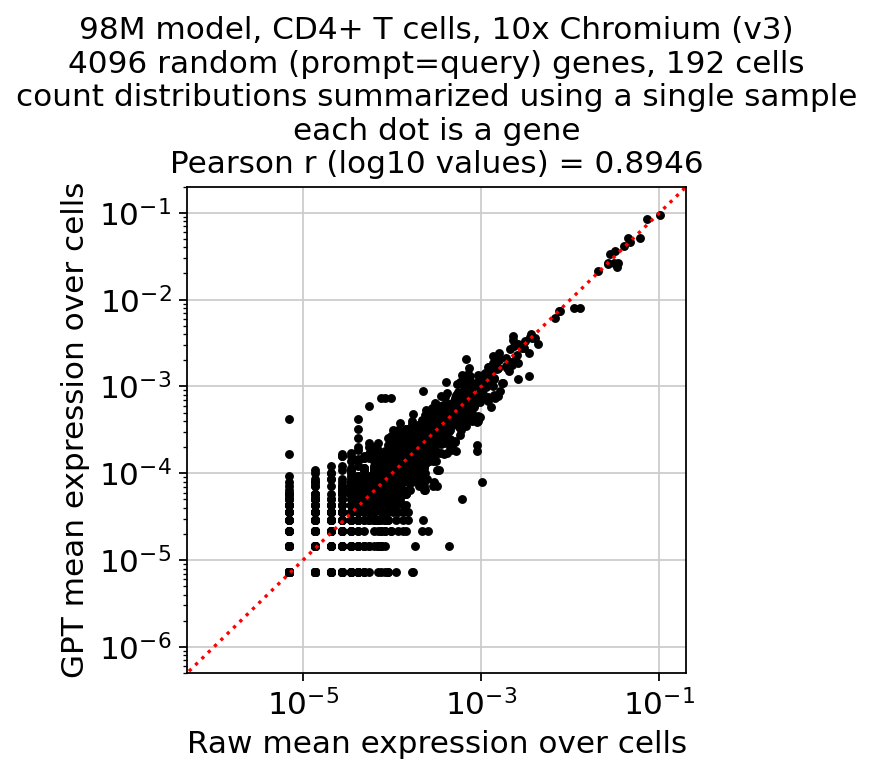

In [16]:
plt.figure(figsize=(4, 4))
plt.loglog(df["raw_mean_norm"], df["gpt_mean_norm"], 'k.')
plt.plot([0, 1], [0, 1], 'r:')
plt.ylim([5e-7, 2e-1])
plt.xlim([5e-7, 2e-1])
# plt.gca().axis('equal')
plt.xlabel("Raw mean expression over cells")
plt.ylabel("GPT mean expression over cells")
plt.title(f'98M model, CD4+ T cells, 10x Chromium (v3)\n'
          f'4096 random (prompt=query) genes, {gene_marginal_mean_nq.shape[0]} cells\n'
          f'count distributions summarized using a single sample\n'
          f'each dot is a gene\n'
          f'Pearson r (log10 values) = {r:.4f}')
plt.show()

In [17]:
# formatted = datetime.now().strftime("%Y_%m_%d_%H_%M")

# filename = f'{formatted}_convert_to_{"_".join(target_assay.split())}'
# clean_filename = re.sub(r'[^a-zA-Z0-9._-]', '', filename)

# target_assay_out_dir = os.path.join(OUT_ADATA_DIR, clean_filename)
# os.makedirs(target_assay_out_dir)

# results_fp1 = os.path.join(target_assay_out_dir, f'original.h5ad')
# results_fp2 = os.path.join(target_assay_out_dir, f'converted.h5ad')
# results_fp3 = os.path.join(target_assay_out_dir, f'converted_means.h5ad')

# sc.write(results_fp1, adata_fixed_genes_original)
# sc.write(results_fp2, adata_fixed_genes_converted)
# sc.write(results_fp2, adata_fixed_genes_means)